# Classification Project

In [45]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df=pd.read_csv('/Users/afsoon/Documents/Data/DataScienceRoadmap/spam_sms/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df.columns=['label','Text']
df['label_enc'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Exploratory Data Analysis

<AxesSubplot:xlabel='label_enc', ylabel='count'>

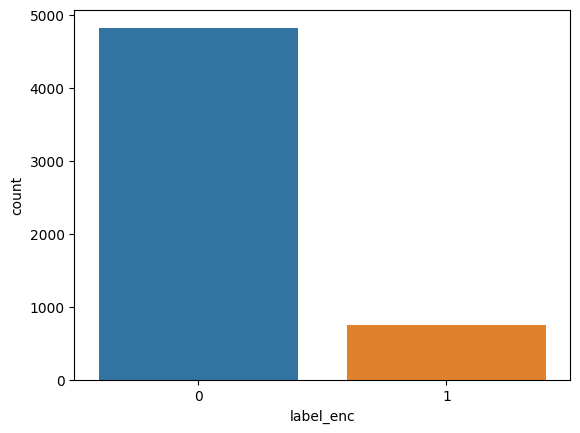

In [4]:
sns.countplot(x=df['label_enc'])

In [5]:
#Since I want to use embeddings in deep learning model, I don't need to balance the data

In [6]:
#Finding average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df.Text])/len(df.Text))
avg_words_len

15

In [7]:
# Finding Total number of unique words in corpus
total_words=[]
for sentence in df.Text:
    for word in sentence.split():
        if word not in total_words:
            total_words.append(word)
            total_words_len=len(total_words)
            
print(total_words_len)

15585


# Baseline Model Development

In [24]:
# Splitting data for Training and testing
X=df['Text']
y=df['label_enc']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [27]:
tfidf_vec=TfidfVectorizer()
tfidf_vec.fit(X_train)
X_train_vec=tfidf_vec.transform(X_train)
X_test_vec=tfidf_vec.transform(X_test)

In [30]:
baseline_model=MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

# Baseline Model Evaluation

In [31]:
accuracy_score(baseline_model.predict(X_test_vec),y_test)

0.9623318385650225

In [33]:
print(classification_report(baseline_model.predict(X_test_vec),y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1007
           1       0.72      1.00      0.84       108

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



<AxesSubplot:>

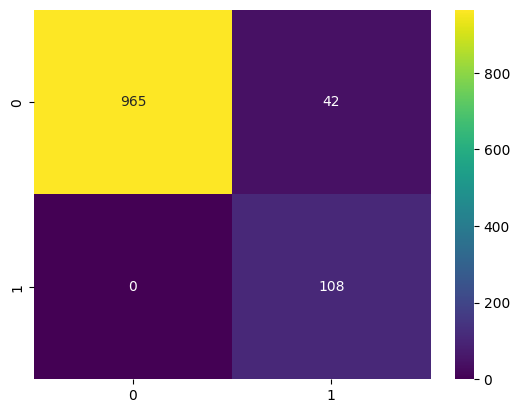

In [47]:
sns.heatmap(confusion_matrix(baseline_model.predict(X_test_vec),y_test),annot=True, fmt='d', cmap='viridis')

In [54]:
model1=keras.Sequential()
model1.add(layers.Embedding(input_dim=total_words_len, output_dim=128, input_length=avg_words_len))
model1.add(layers.GlobalAveragePooling1D())
model1.add(layers.Flatten())
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [57]:
#Print the model summary
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,999,041
Trainable params: 1,999,041
Non-trainable params: 0
____________________________________________